In [14]:
import pandas as pd
import numpy as np
import datetime

import sys
sys.path.insert(1, '../../scripts/')
from s3_support import *

In [15]:
%matplotlib inline

# load data

In [16]:
START_DATE = '2020-10-01'

In [17]:
# form status
q = "select id, status from form"
all_forms = redshift_query_read(q, schema='production')
active_forms = all_forms[all_forms['status']==1]['id'].tolist()

In [18]:
print("{:,} forms".format(len(all_forms)))
print("{:,} forms with active status".format(len(active_forms)))

85,289 forms
34,084 forms with active status


### embeds

In [19]:
# embeds
q = "select widget as form from embed"
embeds = redshift_query_read(q, schema='production')

In [20]:
def is_embed(r):
    if r['form'] in embeds['form'].unique().tolist():
        return True
    return False

### form upgrades

In [21]:
# logged upgrades
q = "select * from syslog_logs where message like '%Qgiv Form Template Upgraded%'"
form_upgrades = redshift_query_read(q, schema="production")[['org', 'form', 'created']]
forms_upgrades_ids_logged = form_upgrades['form'].unique().tolist()

In [22]:
print("first form upgrade: {}".format(form_upgrades['created'].min()))
print("last form upgrade: {}".format(form_upgrades['created'].max()))

first form upgrade: 2020-12-09 15:30:17
last form upgrade: 2023-03-05 15:08:32


In [23]:
# created new template forms
bucket = "qgiv-stats-data"
new_form_template_list = "form_download new template.csv"
new_forms = get_dataframe_from_file(bucket, new_form_template_list)

new_forms['Go Live Date'] = pd.to_datetime(new_forms['Go Live Date'])

new_forms = new_forms[~new_forms['Form ID'].isin(forms_upgrades_ids_logged)]
new_forms = new_forms[(new_forms['Status']=='active')&(new_forms['Go Live Date']>=START_DATE)]
new_forms_ids = new_forms['Form ID'].unique().tolist()

In [24]:
new_forms['Go Live Date'].max()

Timestamp('2023-01-08 00:00:00')

In [25]:
print("{:,} forms upgraded (noted in logs)".format(len(forms_upgrades_ids_logged)))
print("{:,} forms with new template (production export)".format(len(new_forms)))
print("{:,} forms with new template and active status (production export)".format(len(new_forms_ids)))
print()
print("{:,} new template forms & active".format(len([f for f in set(forms_upgrades_ids_logged + new_forms_ids) if f in active_forms])))
print("\n\nlog entries do not imply form status, so here we see an excess but status filters will be applied to remove non-active forms from the dataset")

13,848 forms upgraded (noted in logs)
9,454 forms with new template (production export)
9,454 forms with new template and active status (production export)

18,699 new template forms & active


log entries do not imply form status, so here we see an excess but status filters will be applied to remove non-active forms from the dataset


Last run:
- 2,740 forms upgraded (noted in logs)
- 7,116 forms with new template (production export)
- 5,154 forms with new template and active status (production export)

- 6,050 new template forms intersection

In [26]:
form_upgrades['month'] = form_upgrades['created'].dt.to_period('M')
form_upgrades['active'] = form_upgrades['form'].isin(active_forms)
monthly_upgrades = form_upgrades.groupby(['month', 'active'])['form'].nunique().reset_index()
monthly_upgrades = monthly_upgrades.pivot(index='month', columns='active', values='form').reset_index()
monthly_upgrades.columns = ['month', 'not active', 'active']

print("template conversions")
monthly_upgrades

template conversions


,month,not active,active
0,2020-12,61,152
1,2021-01,255,241
2,2021-02,173,255
3,2021-03,188,267
4,2021-04,141,225
5,2021-05,153,179
6,2021-06,134,203
7,2021-07,141,215
8,2021-08,122,181
9,2021-09,877,3202


In [27]:
new_forms['month'] = new_forms['Go Live Date'].dt.to_period('m')

print("created new template forms")
new_forms.groupby('month')['Form ID'].count().reset_index()

created new template forms


,month,Form ID
0,2020-10,135
1,2020-11,206
2,2020-12,134
3,2021-01,122
4,2021-02,138
5,2021-03,199
6,2021-04,207
7,2021-05,149
8,2021-06,198
9,2021-07,151


In [28]:
def is_new_template(daily_row):
    try:
        # check for log conversion
        if daily_row['form'] in form_upgrades['form'].unique().tolist():
            # is date after logged upgrade date?
            return daily_row['date'] >= form_upgrades[form_upgrades['form']==daily_row['form']]['created'].iloc[0]
        else:
            # form created as new form template
            return daily_row['form'] in new_forms_ids
    except:
        print("error with form {}".format(daily_row['form']))
        raise Exception

### transactions

In [29]:
q_trans_onetime = '''select 
                        id,
                        date, 
                        form, 
                        amount,
                        recurring,
                        source,
                        useragent
                    from transactions
                    where 
                        date>='{}' and
                        status='A' and 
                        recurring=0 and
                        (source='don_form' or source='mobile')'''
trans_onetime = redshift_query_read(q_trans_onetime.format(START_DATE), schema='production')
trans_onetime['is_recurring'] = False

trans_onetime = trans_onetime[trans_onetime['id']!=12774333]

In [30]:
print("{:,} transactions, {:,} unique".format(len(trans_onetime), len(trans_onetime['id'].unique())))
print("{:,} forms".format(len(trans_onetime['form'].unique())))

2,505,869 transactions, 2,505,869 unique
21,367 forms


In [31]:
q_trans_rec = '''select 
                        id,
                        date, 
                        form, 
                        amount,
                        recurring,
                        source,
                        useragent
                    from transactions
                    where 
                        date>='{}' and
                        status='A' and 
                        recurring!=0 and
                        (source='don_form' or source='mobile')'''
trans_rec = redshift_query_read(q_trans_rec.format(START_DATE), schema='production')
trans_rec['is_recurring'] = True

trans_rec = trans_rec[trans_rec['id']!=12774333]

In [32]:
print("{:,} recurring transactions, {:,} unique".format(len(trans_rec), len(trans_rec['id'].unique())))
print("{:,} forms".format(len(trans_rec['form'].unique())))

2,423,978 recurring transactions, 2,423,978 unique
7,641 forms


In [33]:
trans = trans_onetime.append(trans_rec)

In [34]:
print("forms: {:,}".format(trans['form'].nunique()))
print("transactions: {:,}, {:,} unique".format(len(trans), trans['id'].nunique()))
print("one time transactions: {:,}, {:,} unique".format(len(trans[~trans['is_recurring']]), trans[~trans['is_recurring']]['id'].nunique()))
print("recurring transactions: {:,}, {:,} unique".format(len(trans[trans['is_recurring']]), trans[trans['is_recurring']]['id'].nunique()))

forms: 22,794
transactions: 4,929,847, 4,929,847 unique
one time transactions: 2,505,869, 2,505,869 unique
recurring transactions: 2,423,978, 2,423,978 unique


In [35]:
trans['date'].min(), trans['date'].max()

(Timestamp('2020-10-01 00:00:00'), Timestamp('2023-03-05 00:00:00'))

### traffic

In [36]:
q_ga = '''select
                date,
                form,
                devicecategory,
                views,
                bounces
            from googleanalytics_traffic
            where
                date>='{}' and
                (qgiv_frontend=1 or p2p_frontend=1) and
                path not like '%/receipt/%' and
                path not like '%account/%' '''
traffic = redshift_query_read(q_ga.format(START_DATE), schema='production')

In [37]:
traffic = traffic.drop_duplicates()

In [38]:
print("{:,} entries; {:,} unique".format(len(traffic), len(traffic.drop_duplicates())))
print("{:,.2f} entries per form".format(traffic.groupby('form')['views'].count().mean()))
print("{:,.2f} observation dates per form".format(traffic.groupby('form')['date'].nunique().mean()))
print("{:,.2f} views per form".format(traffic.groupby('form')['views'].sum().mean()))
print("{:,.2f} views per form per day".format(traffic.groupby(['form', 'date'])['views'].sum().mean()))

7,224,807 entries; 7,224,807 unique
172.51 entries per form
60.95 observation dates per form
1,365.63 views per form
22.41 views per form per day


In [39]:
traffic['date'].min(), traffic['date'].max()

(Timestamp('2020-10-01 00:00:00'), Timestamp('2023-02-25 00:00:00'))

### merge & compile data

In [40]:
trans['is new template'] = trans[['form', 'date']].apply(is_new_template, axis=1)

In [41]:
trans['is embed'] = trans['form'].isin(embeds['form'].tolist())

In [42]:
trans_all = trans.copy()

trans_onetime = trans[~trans['is_recurring']]
trans_rec = trans[trans['is_recurring']]
trans_rec = trans_rec.groupby('recurring').first().reset_index()

trans = trans_onetime.append(trans_rec)

In [43]:
print("All transactions: {:,} ({:,} unique)".format(len(trans_all), len(trans_all['id'].unique())))
print("One time and originating recurring: {:,}".format(len(trans)))
print()
print("Trans per form: {:,.2f}".format(trans.groupby('form')['amount'].count().mean()))
print("Trans per form per day: {:,.2f}".format(trans.groupby(['form', 'date'])['amount'].count().mean()))
print("One time trans per form: {:,.2f}".format(trans[~trans['is_recurring']].groupby('form')['amount'].count().mean()))
print("Recurring trans per form: {:,.2f}".format(trans[trans['is_recurring']].groupby('form')['amount'].count().mean()))

All transactions: 4,929,847 (4,929,847 unique)
One time and originating recurring: 2,689,540

Trans per form: 117.99
Trans per form per day: 3.53
One time trans per form: 117.28
Recurring trans per form: 24.04


#### daily (all devices) data

In [44]:
# merge to daily
daily_trans = trans.groupby(['form', 'date', 'is_recurring', 'is new template', 'is embed'])['amount'].agg({'count', 'sum'}).reset_index()
daily_trans['trans_count'] = daily_trans['count']
daily_trans['trans_vol'] = daily_trans['sum']
daily_trans.drop(['count', 'sum'], axis=1, inplace=True)

daily_trans_pvt = daily_trans.pivot(index=['form', 'date', 'is new template', 'is embed'], columns='is_recurring', values=['trans_count', 'trans_vol']).reset_index()
cols = ['form', 'date', 'is new template', 'is embed', 
        'trans_count_onetime', 'trans_count_recurring', 
        'trans_vol_onetime', 'trans_vol_recurring']
daily_trans_pvt.columns = cols
daily_trans_pvt.fillna(0, inplace=True)

traffic_agg = traffic.groupby(['date', 'form'])[['views', 'bounces']].sum().reset_index()
dailies = traffic_agg.merge(daily_trans_pvt, on=['date', 'form'], how='outer')
dailies.fillna(0, inplace=True)
dailies = dailies[dailies['views']>0]

In [45]:
print("daily trans agg len: {:,}".format(len(daily_trans)))
print("daily traffic agg len: {:,}".format(len(traffic_agg)))
print("merged dailies len: {:,}".format(len(dailies)))

daily trans agg len: 808,801
daily traffic agg len: 2,552,444
merged dailies len: 2,533,278


In [46]:
print("{:,} forms in transaction aggregates".format(len(daily_trans['form'].unique())))
print("{:,} forms in traffic aggregates".format(len(traffic_agg['form'].unique())))
print("{:,} forms in merged dailies".format(len(dailies['form'].unique())))
print()

print("2021-07-22:")
print("-"*40)
print("{:,} forms in transaction aggregates".format(len(daily_trans[daily_trans['date']=='2021-07-22']['form'].unique())))
print("{:,} forms in traffic aggregates".format(len(traffic_agg[traffic_agg['date']=='2021-07-22']['form'].unique())))
print("{:,} forms in merged dailies".format(len(dailies[dailies['date']=='2021-07-22']['form'].unique())))
print()
print("{:,} one time transactions from transactions data".format(len(trans[(trans['date']=='2021-07-22')&(trans['recurring']==0)])))
print("{:,} one time transactions from transactions aggregated data".format(daily_trans_pvt[(daily_trans_pvt['date']=='2021-07-22')]['trans_count_onetime'].sum()))
print("{:,} forms in merged dailies".format(dailies[dailies['date']=='2021-07-22']['trans_count_onetime'].sum()))
print()

print("2021-05-29:")
print("-"*40)
print("{:,} forms in transaction aggregates".format(len(daily_trans[daily_trans['date']=='2021-05-29']['form'].unique())))
print("{:,} forms in traffic aggregates".format(len(traffic_agg[traffic_agg['date']=='2021-05-29']['form'].unique())))
print("{:,} forms in merged dailies".format(len(dailies[dailies['date']=='2021-05-29']['form'].unique())))
print()
print("{:,} one time transactions from transactions data".format(len(trans[(trans['date']=='2021-05-29')&(trans['recurring']==0)]['id'].unique())))
print("{:,} one time transactions from transactions aggregated data".format(daily_trans_pvt[(daily_trans_pvt['date']=='2021-05-29')]['trans_count_onetime'].sum()))
print("{:,} forms in merged dailies".format(dailies[dailies['date']=='2021-05-29']['trans_count_onetime'].sum()))
print()

print("Dailies w/ > 0 transactions and 0 pageviews:")
print("-"*40)
print("{:,} total dailies entries".format(len(dailies)))
print("{:,} entries".format(len(dailies[(dailies['views']==0)&(dailies['trans_count_onetime']>0)])))
print("{:,} forms".format(len(dailies[(dailies['views']==0)&(dailies['trans_count_onetime']>0)]['form'].unique())))

22,794 forms in transaction aggregates
41,880 forms in traffic aggregates
41,831 forms in merged dailies

2021-07-22:
----------------------------------------
704 forms in transaction aggregates
4,402 forms in traffic aggregates
4,377 forms in merged dailies

1,858 one time transactions from transactions data
1,858.0 one time transactions from transactions aggregated data
1,573.0 forms in merged dailies

2021-05-29:
----------------------------------------
531 forms in transaction aggregates
2,041 forms in traffic aggregates
2,027 forms in merged dailies

1,401 one time transactions from transactions data
1,401.0 one time transactions from transactions aggregated data
845.0 forms in merged dailies

Dailies w/ > 0 transactions and 0 pageviews:
----------------------------------------
2,533,278 total dailies entries
0 entries
0 forms


In [47]:
dailies['conversion'] = (dailies['trans_count_onetime'] + dailies['trans_count_recurring']) / dailies['views']
dailies['conversion_onetime'] = dailies['trans_count_onetime'] / dailies['views']
dailies['conversion_recurring'] = dailies['trans_count_recurring'] / dailies['views']

In [48]:
# removing outliers
dailies = dailies[dailies['conversion']<1.]

In [49]:
dailies = dailies[dailies['date']>=START_DATE]

In [50]:
# limiting to prior report range
dailies = dailies[dailies['date']<='2023-02-01']

In [51]:
# need to tag embed & new template by prior entries for 0 transaction days
dailies['is new template'] = dailies[['form', 'date']].apply(is_new_template, axis=1)

In [52]:
dailies['is embed'] = dailies['form'].isin(embeds['form'].tolist())

In [53]:
count_new_template_onetime = dailies[dailies['is new template']]['trans_count_onetime'].sum()
count_new_template_rec = dailies[dailies['is new template']]['trans_count_recurring'].sum()
count_old_template_onetime = dailies[~dailies['is new template']]['trans_count_onetime'].sum()
count_old_template_rec = dailies[~dailies['is new template']]['trans_count_recurring'].sum()
count_new_template = count_new_template_onetime + count_new_template_rec
count_old_template = count_old_template_onetime + count_old_template_rec

perc_new_template_onetime = (count_new_template_onetime / (count_new_template_onetime + count_old_template_onetime)) * 100.
perc_new_template_rec = (count_new_template_rec / (count_new_template_rec + count_old_template_rec)) * 100.
perc_new_template = (count_new_template / (count_new_template + count_old_template)) * 100.

print("{:,} daily aggregate observations old template".format(len(dailies[~dailies['is new template']])))
print("{:,} daily aggregate observations new template".format(len(dailies[dailies['is new template']])))
print()
print("{:,} ({:.2f}%) transactions new template".format(count_new_template, perc_new_template))
print("{:,} ({:.2f}%) onetime transactions new template".format(count_new_template_onetime, perc_new_template_onetime))
print("{:,} ({:.2f}%) recurring transactions new template".format(count_new_template_rec, perc_new_template_rec))

1,612,417 daily aggregate observations old template
777,124 daily aggregate observations new template

481,678.0 (38.86%) transactions new template
461,343.0 (39.06%) onetime transactions new template
20,335.0 (34.85%) recurring transactions new template


In [54]:
dailies['date'].min(), dailies['date'].max()

(Timestamp('2020-10-01 00:00:00'), Timestamp('2023-02-01 00:00:00'))

# exploration

In [55]:
len_old_temp_zero_conv = len(dailies[(~dailies['is new template'])&(dailies['conversion']==0.0)])
perc_old_temp_zero_conv = (len_old_temp_zero_conv / len(dailies[~dailies['is new template']])) * 100.

len_new_temp_zero_conv = len(dailies[(dailies['is new template'])&(dailies['conversion']==0.0)])
perc_new_temp_zero_conv = (len_new_temp_zero_conv / len(dailies[dailies['is new template']])) * 100.

print("{:,} ({:.2f}%) old template observations w/ 0% conversion".format(len_old_temp_zero_conv, perc_old_temp_zero_conv))
print("{:,} ({:.2f}%) new template observations w/ 0% conversion".format(len_new_temp_zero_conv, perc_new_temp_zero_conv))

1,441,636 (89.41%) old template observations w/ 0% conversion
647,397 (83.31%) new template observations w/ 0% conversion


In [56]:
template_date_counts = dailies.groupby(['date', 'is new template'])['conversion'].count().reset_index()
template_date_counts = template_date_counts.pivot(index='date', columns='is new template', values='conversion').reset_index()
template_date_counts.columns = ['date', 'old template', 'new template']

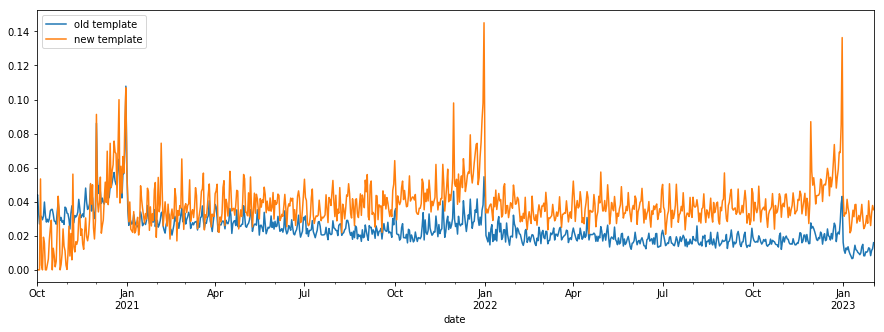

In [57]:
template_date_conv = dailies.groupby(['date', 'is new template'])['conversion'].mean().reset_index()
template_date_conv = template_date_conv.pivot(index='date', columns='is new template', values='conversion').reset_index()
template_date_conv.columns = ['date', 'old template', 'new template']
template_date_conv.plot(x='date', figsize=(15,5))

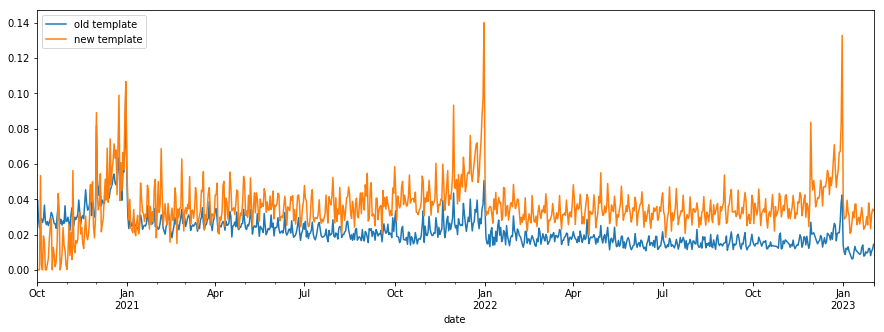

In [58]:
temp_ot_date_conv = dailies.groupby(['date', 'is new template'])['conversion_onetime'].mean().reset_index()
temp_ot_date_conv = temp_ot_date_conv.pivot(index='date', columns='is new template', values='conversion_onetime').reset_index()
temp_ot_date_conv.columns = ['date', 'old template', 'new template']
temp_ot_date_conv.plot(x='date', figsize=(15,5))

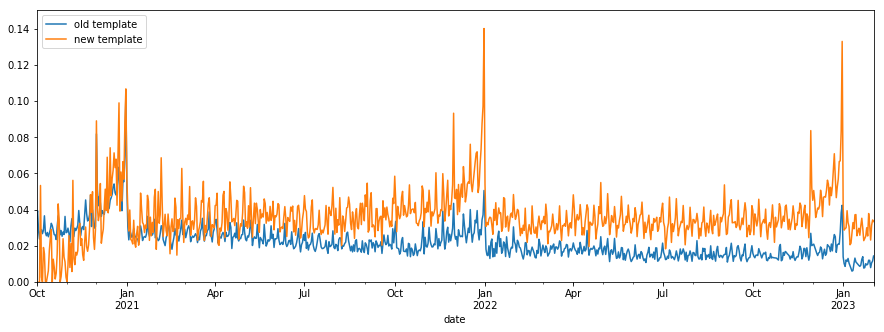

In [59]:
temp_ot_date_conv.plot(x='date', figsize=(15,5), ylim=(0,0.15))

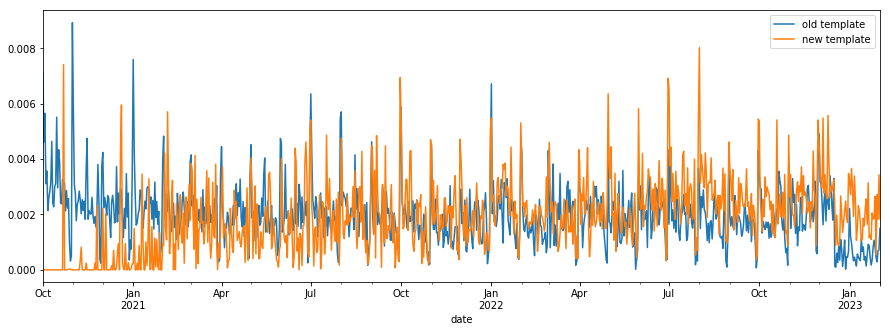

In [60]:
temp_rec_date_conv = dailies.groupby(['date', 'is new template'])['conversion_recurring'].mean().reset_index()
temp_rec_date_conv = temp_rec_date_conv.pivot(index='date', columns='is new template', values='conversion_recurring').reset_index()
temp_rec_date_conv.columns = ['date', 'old template', 'new template']
temp_rec_date_conv.plot(x='date', figsize=(15,5))

In [61]:
dailies[dailies['is new template']].sort_values('conversion_recurring', ascending=False).head()

,date,form,views,bounces,is new template,is embed,trans_count_onetime,trans_count_recurring,trans_vol_onetime,trans_vol_recurring,conversion,conversion_onetime,conversion_recurring
1648360,2022-04-28,986366,265.0,7.0,True,False,1.0,253.0,0.00,15167.78,0.958491,0.003774,0.954717
1919884,2022-08-01,981939,8.0,0.0,True,False,0.0,7.0,0.00,3515.00,0.875000,0.000000,0.875000
1992243,2022-08-25,977625,11.0,0.0,True,True,1.0,9.0,26.25,401.75,0.909091,0.090909,0.818182
1687626,2022-05-11,959515,5.0,0.0,True,True,0.0,4.0,0.00,63.00,0.800000,0.000000,0.800000
2340127,2022-12-10,991273,5.0,0.0,True,True,0.0,4.0,0.00,92.64,0.800000,0.000000,0.800000


In [62]:
len(dailies), len(dailies[dailies['conversion']>1.]), "{:.2f}%".format((len(dailies[dailies['conversion']>1.]) / len(dailies)) * 100.)

(2389541, 0, '0.00%')

In [63]:
over_conv_forms = dailies[dailies['conversion']>1.]['form'].unique().tolist()
intersect_over_conv = [f for f in over_conv_forms if f in dailies[dailies['conversion']<1.]['form'].unique()]

print("{:,} forms w/ > 100% conversion".format(len(over_conv_forms)))
print("{:,} forms overlap w/ < 100% conversion".format(len(intersect_over_conv)))

0 forms w/ > 100% conversion
0 forms overlap w/ < 100% conversion


In [64]:
print(len(dailies[dailies['conversion_onetime']>1.]), len(dailies[dailies['conversion_recurring']>1.]))
print("one time: {:.2f}%".format((len(dailies[dailies['conversion_onetime']>1.]) / len(dailies)) * 100.))
print("recurring: {:.2f}%".format((len(dailies[dailies['conversion_recurring']>1.]) / len(dailies)) * 100.))

0 0
one time: 0.00%
recurring: 0.00%


In [65]:
print("total: {:,}".format(len(dailies[dailies['conversion']>1.])))
print("new template: {:,}".format(len(dailies[(dailies['is new template'])&(dailies['conversion']>1.)])))
print("old template: {:,}".format(len(dailies[(dailies['conversion']>1.)&(~dailies['is new template'])])))
print("embed: {:,}".format(len(dailies[(dailies['conversion']>1.)&(dailies['is embed'])])))
print("not embed: {:,}".format(len(dailies[(dailies['conversion']>1.)&(~dailies['is embed'])])))

print()
print("old template & embed: {:,}".format(len(dailies[(~dailies['is new template'])&(dailies['is embed'])&(dailies['conversion']>1.)])))

total: 0
new template: 0
old template: 0
embed: 0
not embed: 0

old template & embed: 0


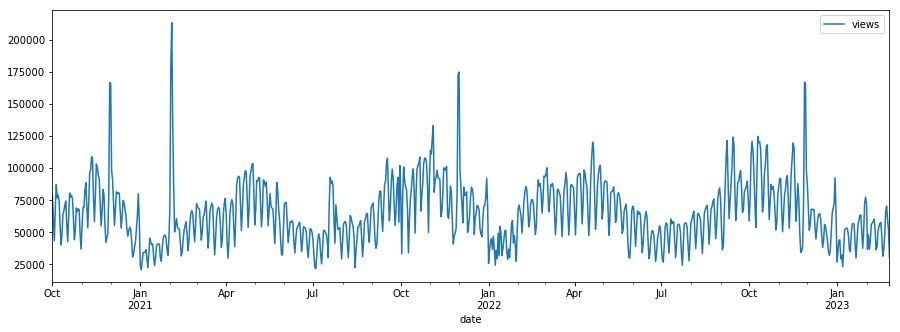

In [66]:
traff_date = traffic.groupby('date')['views'].sum().reset_index()
traff_date.plot(x='date', figsize=(15,5))

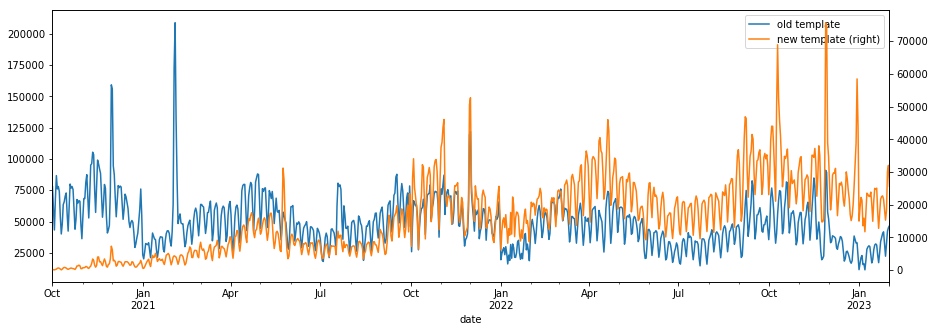

In [67]:
template_date_traf = dailies.groupby(['date', 'is new template'])['views'].sum().reset_index()
template_date_traf = template_date_traf.pivot(index='date', columns='is new template', values='views').reset_index()
template_date_traf.columns = ['date', 'old template', 'new template']
template_date_traf.plot(x='date', secondary_y='new template', figsize=(15,5))

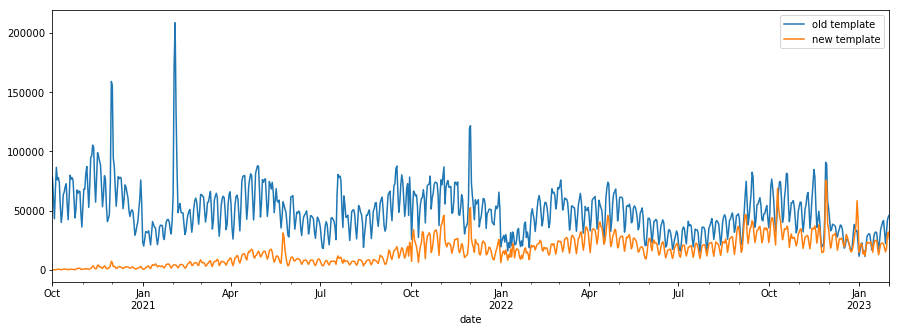

In [68]:
template_date_traf.plot(x='date', figsize=(15,5))

In [69]:
dailies['trans_count'] = dailies['trans_count_onetime'] + dailies['trans_count_recurring']

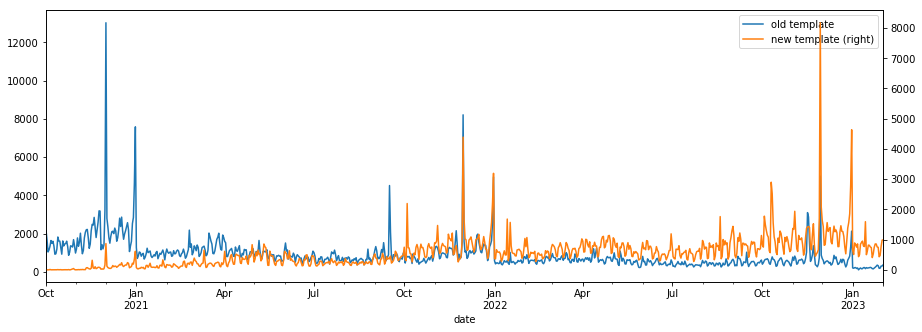

In [70]:
template_date_trans = dailies.groupby(['date', 'is new template'])['trans_count'].sum().reset_index()
template_date_trans = template_date_trans.pivot(index='date', columns='is new template', values='trans_count').reset_index()
template_date_trans.columns = ['date', 'old template', 'new template']
template_date_trans.plot(x='date', secondary_y='new template', figsize=(15,5))

In [71]:
dailies['trans_vol'] = dailies['trans_vol_onetime'] + dailies['trans_vol_recurring']

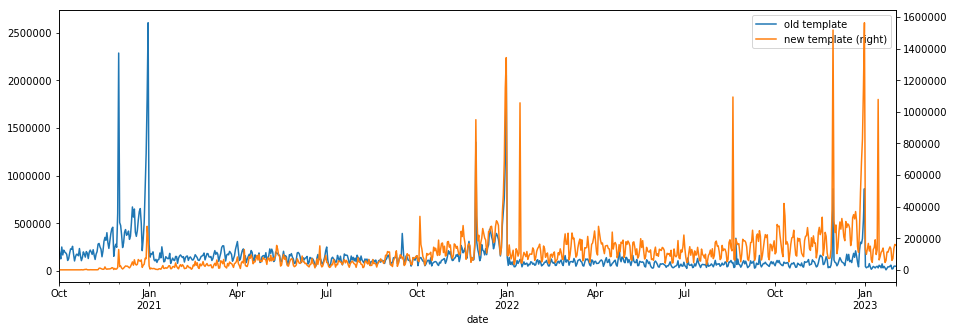

In [72]:
template_date_trans = dailies.groupby(['date', 'is new template'])['trans_vol'].sum().reset_index()
template_date_trans = template_date_trans.pivot(index='date', columns='is new template', values='trans_vol').reset_index()
template_date_trans.columns = ['date', 'old template', 'new template']
template_date_trans.plot(x='date', secondary_y='new template', figsize=(15,5))

In [73]:
template_date_trans.iloc[-28:-23]

,date,old template,new template
826,2023-01-05,76776.15,119177.48
827,2023-01-06,41706.97,149761.01
828,2023-01-07,17293.34,63518.16
829,2023-01-08,29659.05,47499.43
830,2023-01-09,47419.49,129178.05


_Re: new template spike on 10-04, secure reports for donation form processing shows a similar spike so it appears legit_

#### monthly median transactions

In [74]:
trans['month'] = trans['date'].dt.to_period('M')
trans_monthly_median = trans[~trans['is_recurring']].groupby(['month', 'is new template'])['amount'].agg({'median', 'count'}).reset_index()

In [75]:
monthly_medians = trans_monthly_median.pivot(index='month', columns='is new template', values=['count', 'median']).reset_index()
monthly_medians.columns = ['month', 'old template count', 'new template count', 'old template median', 'new template median']

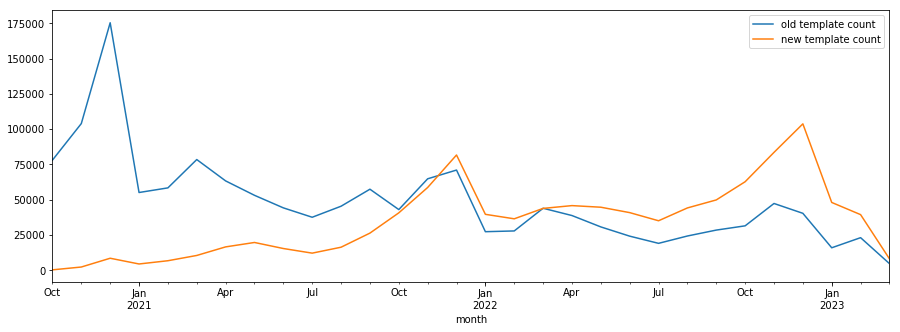

In [76]:
monthly_medians.plot(x='month', y=['old template count', 'new template count'], figsize=(15,5))

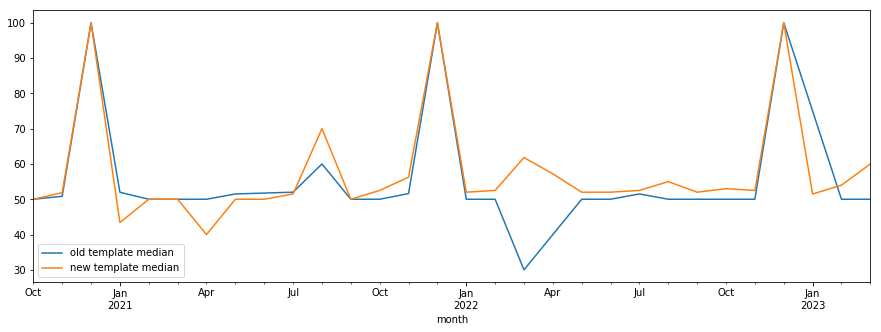

In [77]:
monthly_medians.plot(x='month', y=['old template median', 'new template median'], figsize=(15,5))

In [78]:
trans_monthly_sums = trans[~trans['is_recurring']].groupby(['month', 'is new template'])['amount'].sum().reset_index()

In [79]:
monthly_sums = trans_monthly_sums.pivot(index='month', columns='is new template', values=['amount']).reset_index()
monthly_sums.columns = ['month', 'old template vol', 'new template vol']

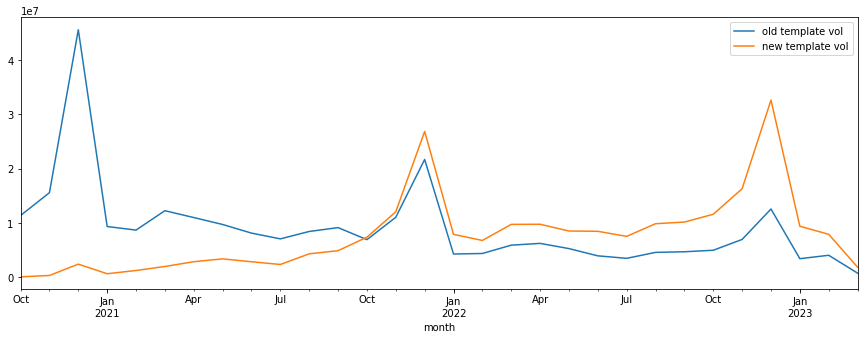

In [80]:
monthly_sums.plot(x='month', figsize=(15,5))

In [81]:
trans_monthly_counts = trans.groupby(['month', 'is new template', 'is_recurring'])['id'].nunique().reset_index()
trans_monthly_counts = trans_monthly_counts.pivot(index='month', columns=['is new template', 'is_recurring'], values='id').reset_index()
trans_monthly_counts.columns = ['month', 'one time old template', 
                                'recurring old template', 'one time new template',
                                'recurring new template']

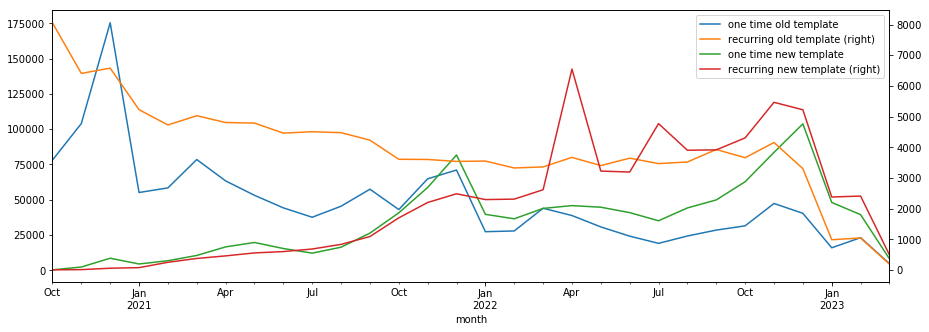

In [82]:
secondary_ys = ['recurring old template', 'recurring new template']
trans_monthly_counts.plot(x='month', secondary_y=secondary_ys, figsize=(15,5))

#### monthly onetime/recurring ratio

In [83]:
trans['month'] = trans['date'].dt.to_period('m')
monthly_ratios = trans.groupby(['month', 'is_recurring', 'is new template'])['id'].nunique().reset_index()

In [84]:
monthly_ratios = monthly_ratios.pivot(index='month', columns=['is_recurring', 'is new template'], values='id').reset_index()
monthly_ratios.columns = ['month', 'onetime old template', 'onetime new template', 'recurring old template', 'recurring new template']
monthly_ratios['new template ratio'] = monthly_ratios['onetime new template'] / monthly_ratios['recurring new template']
monthly_ratios['old template ratio'] = monthly_ratios['onetime old template'] / monthly_ratios['recurring old template']

In [85]:
monthly_ratios.tail(12)

,month,onetime old template,onetime new template,recurring old template,recurring new template,new template ratio,old template ratio
18,2022-04,38827,45860,3670,6548,7.003665,10.579564
19,2022-05,30768,44723,3403,3224,13.871898,9.041434
20,2022-06,24225,40895,3644,3192,12.811717,6.647914
21,2022-07,19131,35127,3468,4770,7.364151,5.516436
22,2022-08,24331,44217,3520,3902,11.331881,6.912216
23,2022-09,28521,49888,3927,3915,12.742784,7.262796
24,2022-10,31535,62776,3658,4305,14.582114,8.620831
25,2022-11,47371,83577,4155,5464,15.295937,11.400963
26,2022-12,40400,103779,3303,5222,19.873420,12.231305
27,2023-01,15988,48099,987,2379,20.218159,16.198582


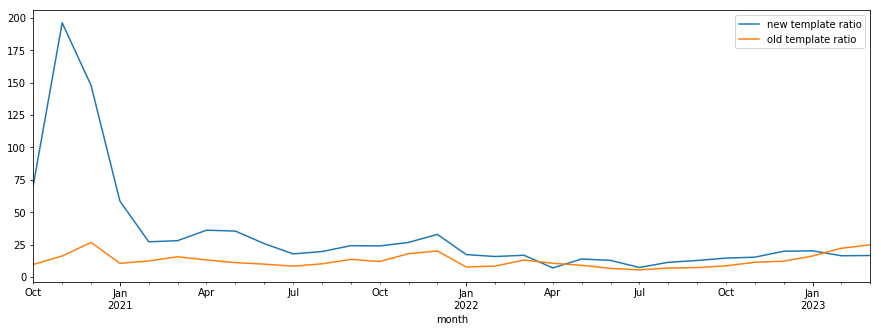

In [86]:
monthly_ratios[['month', 'new template ratio', 'old template ratio']].plot(x='month', figsize=(15,5))

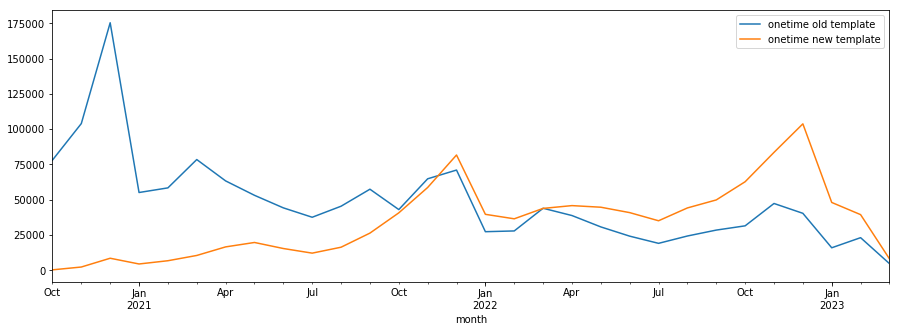

In [87]:
monthly_ratios[['month', 'onetime old template', 'onetime new template']].plot(x='month', figsize=(15,5))

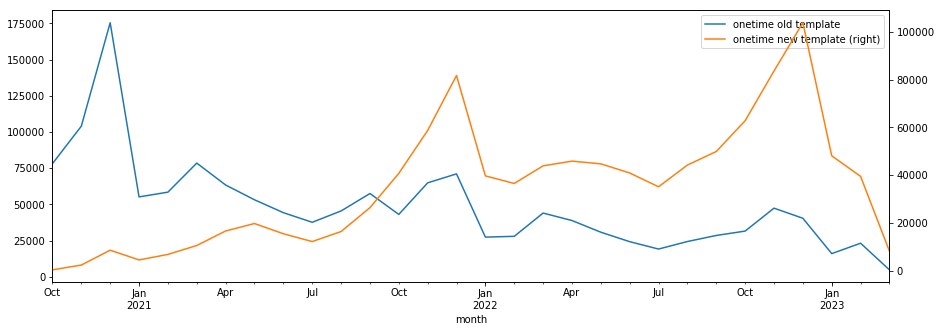

In [88]:
monthly_ratios[['month', 'onetime old template', 'onetime new template']].plot(x='month', secondary_y='onetime new template', figsize=(15,5))

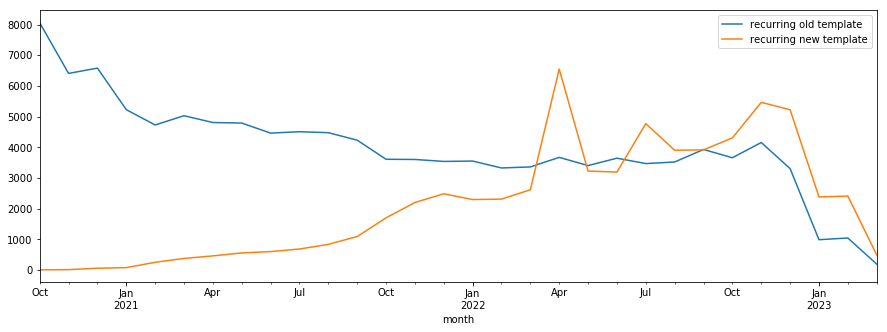

In [89]:
monthly_ratios[['month', 'recurring old template', 'recurring new template']].plot(x='month', figsize=(15,5))

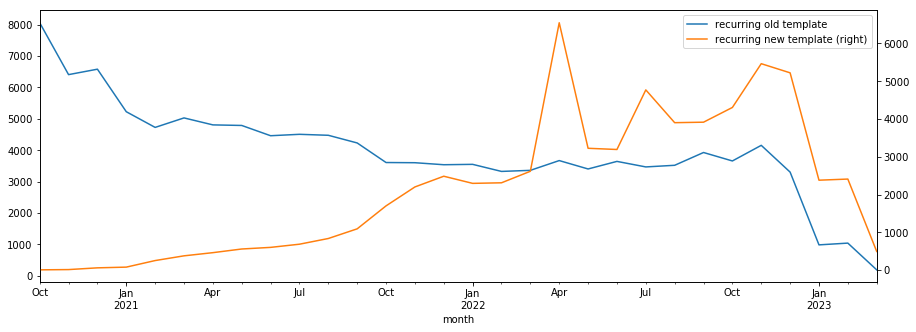

In [90]:
monthly_ratios[['month', 'recurring old template', 'recurring new template']].plot(x='month', secondary_y='recurring new template', figsize=(15,5))

- one time / recurring over time, one time, recurring, recurring all vs originating
- over time, table

In [91]:
daily_onetime = trans[~trans['is_recurring']].groupby(['date', 'is new template'])['id'].nunique().reset_index()
daily_onetime = daily_onetime.pivot(index='date', columns='is new template', values='id').reset_index()
daily_onetime.columns = ['date', 'old template onetime', 'new template onetime']

daily_rec_originating = trans[trans['is_recurring']].groupby(['date', 'is new template'])['id'].nunique().reset_index()
daily_rec_originating = daily_rec_originating.pivot(index='date', columns='is new template', values='id').reset_index()
daily_rec_originating.columns = ['date', 'old template rec origin', 'new template rec origin']

daily_rec_all = trans_all[trans_all['is_recurring']].groupby(['date', 'is new template'])['id'].nunique().reset_index()
daily_rec_all = daily_rec_all.pivot(index='date', columns='is new template', values='id').reset_index()
daily_rec_all.columns = ['date', 'old template rec all', 'new template rec all']

daily_trans = daily_onetime.merge(daily_rec_originating, on='date', how='outer').merge(daily_rec_all, on='date', how='outer')

In [92]:
daily_trans.tail(3)

,date,old template onetime,new template onetime,old template rec origin,new template rec origin,old template rec all,new template rec all
883,2023-03-03,1081.0,1743.0,31.0,98.0,1493.0,1918.0
884,2023-03-04,770.0,1097.0,41.0,75.0,1173.0,1582.0
885,2023-03-05,677.0,1214.0,29.0,62.0,1377.0,1794.0


In [93]:
daily_trans['new template onetime / rec origin'] = daily_trans['new template onetime'] / daily_trans['new template rec origin']
daily_trans['new template onetime / rec all'] = daily_trans['new template onetime'] / daily_trans['new template rec all']

daily_trans['old template onetime / rec origin'] = daily_trans['old template onetime'] / daily_trans['old template rec origin']
daily_trans['old template onetime / rec all'] = daily_trans['old template onetime'] / daily_trans['old template rec all']

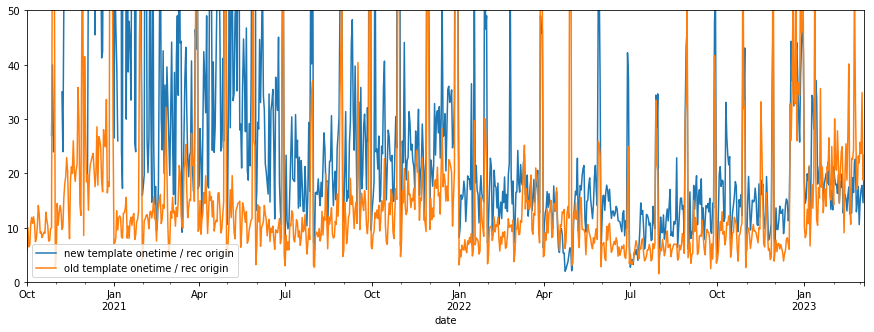

In [94]:
cols = ['date', 'new template onetime / rec origin', 
        'old template onetime / rec origin']
daily_trans[cols].plot(x='date', ylim=(0,50), figsize=(15,5))

In [95]:
cols = ['old template onetime', 'new template onetime',
       'old template rec origin', 'new template rec origin',
       'old template rec all', 'new template rec all']
monthly_trans = daily_trans.groupby(daily_trans['date'].dt.to_period('m'))[cols].sum().reset_index()

In [96]:
monthly_trans['new template onetime / rec origin'] = monthly_trans['new template onetime'] / monthly_trans['new template rec origin']
monthly_trans['new template onetime / rec all'] = monthly_trans['new template onetime'] / monthly_trans['new template rec all']

monthly_trans['old template onetime / rec origin'] = monthly_trans['old template onetime'] / monthly_trans['old template rec origin']
monthly_trans['old template onetime / rec all'] = monthly_trans['old template onetime'] / monthly_trans['old template rec all']

In [97]:
monthly_trans

,date,old template onetime,new template onetime,old template rec origin,new template rec origin,old template rec all,new template rec all,new template onetime / rec origin,new template onetime / rec all,old template onetime / rec origin,old template onetime / rec all
0,2020-10,78102.0,355.0,8057.0,5.0,58617.0,30.0,71.000000,11.833333,9.693683,1.332412
1,2020-11,103980.0,2355.0,6406.0,12.0,60845.0,133.0,196.250000,17.706767,16.231658,1.708933
2,2020-12,175402.0,8578.0,6579.0,58.0,64788.0,491.0,147.896552,17.470468,26.660891,2.707322
3,2021-01,55141.0,4511.0,5225.0,77.0,65167.0,986.0,58.584416,4.575051,10.553301,0.846149
4,2021-02,58423.0,6812.0,4726.0,251.0,65799.0,2442.0,27.139442,2.789517,12.362040,0.887901
5,2021-03,78491.0,10547.0,5028.0,376.0,68584.0,3512.0,28.050532,3.003132,15.610780,1.144451
6,2021-04,63363.0,16617.0,4806.0,460.0,68272.0,5133.0,36.123913,3.237288,13.184145,0.928096
7,2021-05,53158.0,19743.0,4788.0,557.0,68972.0,6521.0,35.445242,3.027603,11.102339,0.770719
8,2021-06,44265.0,15465.0,4461.0,600.0,66227.0,7865.0,25.775000,1.966306,9.922663,0.668383
9,2021-07,37615.0,12191.0,4506.0,684.0,66094.0,10368.0,17.823099,1.175829,8.347759,0.569114


#### monthly volumes

In [98]:
these_trans = trans[(trans['is new template'])&(trans['month']=='2021-07')]

print("07/2021 new template transactions: {:,}".format(len(these_trans)))
print("\tunique transactions: {:,}".format(these_trans['id'].nunique()))
print()

these_trans.sort_values('amount').tail()

07/2021 new template transactions: 12,875
	unique transactions: 12,875



,id,date,form,amount,recurring,source,useragent,is_recurring,is new template,is embed,month
1729867,12813328,2021-07-25,972936,11600.0,0,don_form,Mozilla50WindowsNT100Win64x64AppleWebKit53736K...,False,True,False,2021-07
1515393,12665227,2021-07-01,966785,16000.0,0,don_form,Mozilla50WindowsNT100Win64x64AppleWebKit53736K...,False,True,True,2021-07
1522031,12825913,2021-07-27,966785,16960.0,0,don_form,Mozilla50WindowsNT100Win64x64AppleWebKit53736K...,False,True,True,2021-07
1695001,12818390,2021-07-26,971607,25000.0,0,don_form,Mozilla50WindowsNT100Win64x64rv900Gecko2010010...,False,True,True,2021-07
1369746,12788285,2021-07-21,965703,25000.0,0,mobile,Mozilla50iPhoneCPUiPhoneOS146likeMacOSXAppleWe...,False,True,False,2021-07


In [99]:
monthly_volume = trans.groupby(['month', 'is new template'])['amount'].sum().reset_index()

In [100]:
monthly_vol = monthly_volume.pivot(index='month', columns='is new template', values='amount').reset_index()
monthly_vol.columns = ['month', 'old template volume', 'new template volume']
monthly_vol.tail()

,month,old template volume,new template volume
25,2022-11,7161884.93,16858161.09
26,2022-12,12738765.09,33225707.15
27,2023-01,3522613.87,9601122.54
28,2023-02,4113257.92,8189368.17
29,2023-03,743194.96,1872121.62


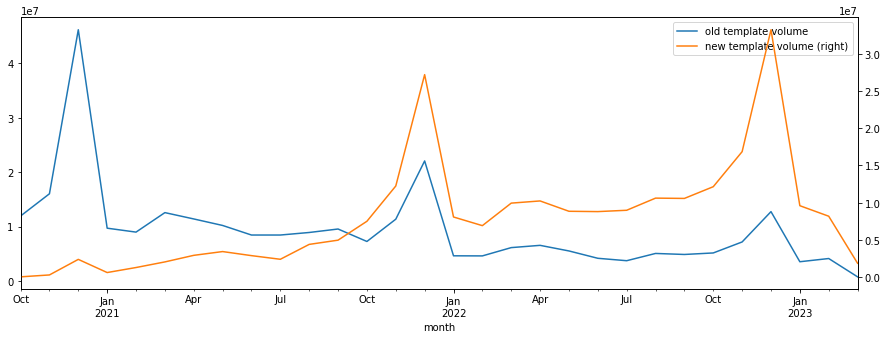

In [101]:
monthly_vol.plot(x='month', secondary_y='new template volume', figsize=(15,5))

#### form sample sizes

In [102]:
print("Dailies:")
print("\tnew template: {:,}".format(len(dailies[dailies['is new template']]['form'].unique())))
print("\told template: {:,}".format(len(dailies[~dailies['is new template']]['form'].unique())))
print()

print("Transactions:")
print("\tnew template: {:,}".format(len(trans[trans['is new template']]['form'].unique())))
print("\told template: {:,}".format(len(trans[~trans['is new template']]['form'].unique())))

Dailies:
	new template: 15,074
	old template: 31,040

Transactions:
	new template: 11,542
	old template: 14,476


In [103]:
daily_forms = dailies.groupby(['date', 'is new template'])['form'].nunique().reset_index()
daily_forms = daily_forms.pivot(index='date', columns='is new template', values='form').reset_index()
daily_forms.columns = ['date', 'old template', 'new template']

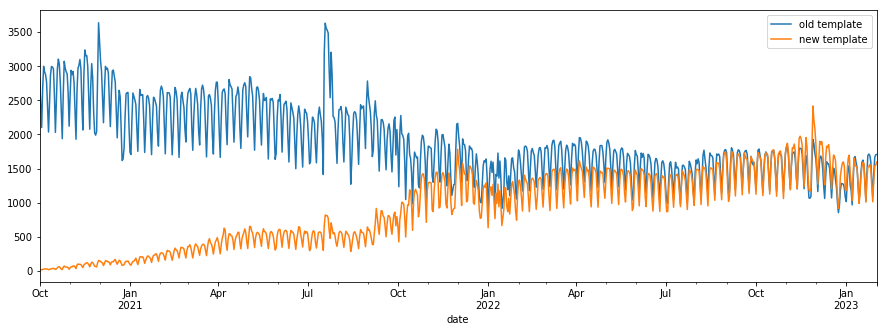

In [104]:
daily_forms.plot(x='date', figsize=(15,5))

In [105]:
daily_trans_forms = trans.groupby(['date', 'is new template'])['form'].nunique().reset_index()
daily_trans_forms = daily_trans_forms.pivot(index='date', columns='is new template', values='form').reset_index()
daily_trans_forms.columns = ['date', 'old template', 'new template']

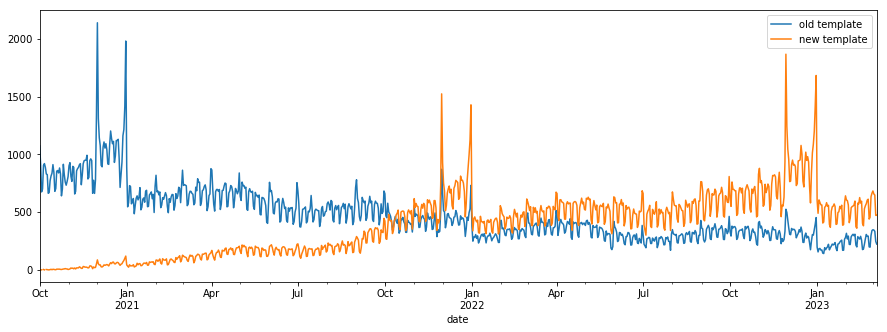

In [106]:
daily_trans_forms.plot(x='date', figsize=(15,5))

#### trans vs dailies one time

In [107]:
daily_onetime = dailies.groupby(['date', 'is new template'])['trans_count_onetime'].sum().reset_index()
daily_onetime = daily_onetime.pivot(index='date', columns='is new template', values='trans_count_onetime').reset_index()
daily_onetime.columns = ['date', 'old template', 'new template']

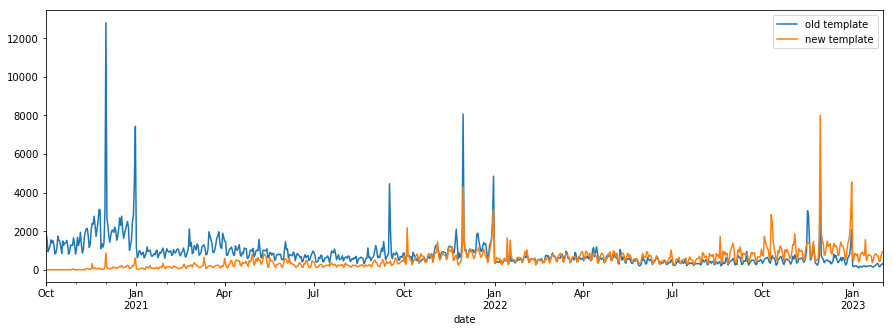

In [108]:
daily_onetime.plot(x='date', figsize=(15,5))

In [109]:
trans_onetime = trans[trans['recurring']==0].groupby(['date', 'is new template'])['id'].nunique().reset_index()
trans_onetime = trans_onetime.pivot(index='date', columns='is new template', values='id').reset_index()
trans_onetime.columns = ['date', 'old template', 'new template']

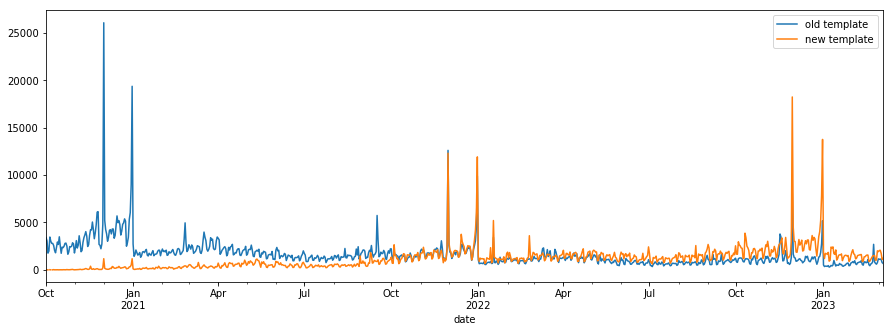

In [110]:
trans_onetime.plot(x='date', figsize=(15,5))

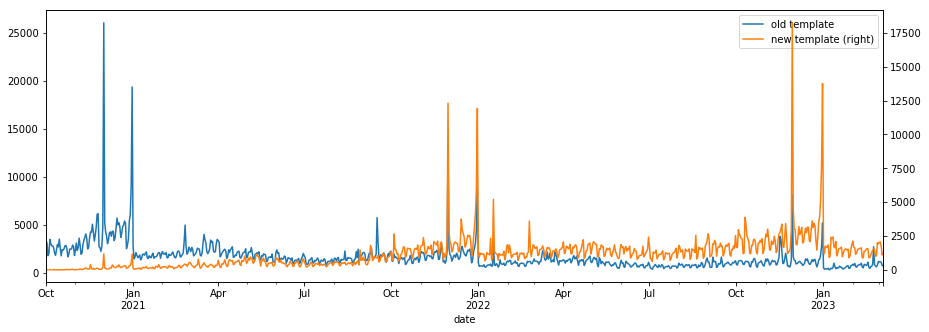

In [111]:
trans_onetime.plot(x='date', secondary_y='new template', figsize=(15,5))

In [112]:
iso_trans = trans[(trans['date']=='2021-02-25')&(trans['is new template'])]
iso_trans.groupby('form')['amount'].sum().reset_index().sort_values('amount').tail()

,form,amount
69,967186,5387.50
79,967822,6298.12
0,17,8256.00
112,969772,10425.50
33,953274,18676.70


#### active forms per month

last 90 days, new forms represent 40% by sample size but 6% of the pageviews 

In [113]:
forms_by_month_trans = trans.groupby(['month', 'is new template'])['form'].nunique().reset_index()
forms_by_month_trans = forms_by_month_trans.pivot(index='month', columns='is new template', values='form').reset_index()
forms_by_month_trans.columns = ['month', 'old template forms', 'new template forms']
forms_by_month_trans

,month,old template forms,new template forms
0,2020-10,3987,42
1,2020-11,4121,147
2,2020-12,4538,289
3,2021-01,3350,334
4,2021-02,3148,476
5,2021-03,3427,705
6,2021-04,3337,822
7,2021-05,3280,936
8,2021-06,3029,981
9,2021-07,2820,1007


In [114]:
dailies['month'] = dailies['date'].dt.to_period('m')
dailies_traffic_by_month = dailies.groupby(['month', 'is new template'])['views'].sum().reset_index()
dailies_traffic_by_month = dailies_traffic_by_month.pivot(index='month', columns='is new template', values='views').reset_index()
dailies_traffic_by_month.columns = ['month', 'old template', 'new template']

dailies_traffic_by_month['total'] = dailies_traffic_by_month['old template'] + dailies_traffic_by_month['new template']
dailies_traffic_by_month['new template percentage'] = dailies_traffic_by_month['new template'] / dailies_traffic_by_month['total']
dailies_traffic_by_month

,month,old template,new template,total,new template percentage
0,2020-10,1950631.0,16515.0,1967146.0,0.008395
1,2020-11,2299344.0,61019.0,2360363.0,0.025852
2,2020-12,1946504.0,66906.0,2013410.0,0.033230
3,2021-01,1012338.0,91970.0,1104308.0,0.083283
4,2021-02,1729415.0,122039.0,1851454.0,0.065915
5,2021-03,1662014.0,196229.0,1858243.0,0.105599
6,2021-04,1873591.0,347532.0,2221123.0,0.156467
7,2021-05,1750765.0,385974.0,2136739.0,0.180637
8,2021-06,1307453.0,232212.0,1539665.0,0.150820
9,2021-07,1332117.0,217501.0,1549618.0,0.140358


In [115]:
#dailies.to_csv("dailies.csv", index=False)

# report

calculate data points from 01-2022 forward, report to include only 2023 with year over year changes

In [116]:
#dailies = pd.read_csv("dailies.csv")

In [132]:
def report(df, df_all_trans):
    df = df.copy().replace(np.inf, np.nan)
    return {
        'form sample size': len(df_all_trans['form'].unique().tolist()),
        'transactions': df_all_trans[df_all_trans['recurring']==0]['id'].nunique() + df['trans_count_recurring'].sum(),
        'transactions per form': df_all_trans.groupby('form')['id'].count().mean(),
        'conversion': df['conversion'].mean(),
        'conversion onetime': df['conversion_onetime'].mean(),
        'conversion recurring': df['conversion_recurring'].mean(),
        'mean transaction onetime': df['trans_vol_onetime'].sum() / df['trans_count_onetime'].sum(),
        'median transaction onetime': df_all_trans[~df_all_trans['is_recurring']]['amount'].median(),
        'mean transaction recurring': df['trans_vol_recurring'].sum() / df['trans_count_recurring'].sum(),
        'median transaction recurring': df_all_trans[df_all_trans['is_recurring']]['amount'].median(),
        'onetime/recurring': df['trans_count_onetime'].sum() / df['trans_count_recurring'].sum(),
        'pageviews': df['views'].sum(),
        'bounce rate': df['bounces'].sum() / df['views'].sum(),
        'transactions one time': len(df_all_trans[~df_all_trans['is_recurring']]),
        'transactions origin recurring': df['trans_count_recurring'].sum(), 
        'transactions all recurring': len(df_all_trans[df_all_trans['is_recurring']])
    }

In [118]:
# buid month ranges list to iterate through
month_ranges = []
for y in [2022, 2023]:
    for m in range(1, 13):
        y_1 = y_2 = y
        m_1 = m
        m_2 = m + 1
        if m == 12:
            m_2 = 1
            y_2 += 1
        month_ranges.append(("{:02d}-01-{}".format(m_1, y_1), ("{:02d}-01-{}".format(m_2, y_2))))

In [183]:
# build monthly dataframe from 01-2022 forward
monthly_data = None
for m in month_ranges:
    this_df = dailies[(dailies['date']>=m[0])&(dailies['date']<m[1])]
    this_df_all = trans_all[(trans_all['date']>=m[0])&(trans_all['date']<m[1])]
    
    new_template_data = report(this_df[this_df['is new template']], this_df_all[this_df_all['is new template']])
    old_template_data = report(this_df[~this_df['is new template']], this_df_all[~this_df_all['is new template']])
    
    # @TODO need to reorganize to have all month's data in single row
    #        currently split by new/old which makes YoY messy
    
    report_df = pd.DataFrame({'new template': new_template_data,
                             'old template': old_template_data})
    
    report_df = report_df.transpose()
    report_df['date'] = m[0]
    report_df['pageviews'] = report_df['pageviews'] / report_df['pageviews'].sum()
    
    monthly_data = pd.concat([monthly_data, report_df])

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


In [184]:
monthly_data = monthly_data.reset_index()
monthly_data['template'] = monthly_data['index'].str.replace(' template', '')
monthly_data.drop('index', axis=1, inplace=True)

In [185]:
vals_cols = [c for c in monthly_data.columns if c != 'template' and c != 'date']
monthly_pvt = monthly_data.pivot(index=['date'], columns='template', values=vals_cols)

In [186]:
monthly_pvt = monthly_pvt.reset_index().sort_values('date', ascending=True)

In [188]:
monthly_pvt.dropna()

date form sample size         transactions           \
template                          new     old          new      old   
0         01-01-2022           3355.0  2864.0      40349.0  28632.0   
1         01-01-2023           4534.0  2603.0      48988.0  16265.0   
2         02-01-2022           3454.0  2948.0      37129.0  29155.0   
3         02-01-2023           4795.0  2910.0      39503.0  23167.0   
4         03-01-2022           3795.0  3151.0      44624.0  45167.0   
6         04-01-2022           3860.0  3154.0      49773.0  40014.0   
8         05-01-2022           3950.0  3041.0      45674.0  31796.0   
10        06-01-2022           3944.0  2879.0      41836.0  25375.0   
12        07-01-2022           3923.0  2698.0      36904.0  20291.0   
14        08-01-2022           4183.0  2814.0      45341.0  25584.0   
16        09-01-2022           4409.0  2859.0      50819.0  29758.0   
18        10-01-2022           4582.0  2786.0      63850.0  32655.0   
20        11-01-2022           5082.0  2737.0      85029.0  48609.0   
22        12-01-2022           5248.0  2603.0     105284.0  41351.0   

         transactions per form            conversion            \
template                   new        old        new       old   
0                    21.196423  28.575070   0.038289  0.021344   
1                    20.271063  23.813677   0.031870  0.010691   
2                    19.838448  27.629579   0.033311  0.019183   
3                    18.195620  22.092096   0.035325  0.015941   
4                    20.710408  30.813710   0.033622  0.020151   
6                    33.211399  29.061826   0.037029  0.020492   
8                    21.877215  26.996712   0.036043  0.017954   
10                   20.128803  26.288989   0.035607  0.016794   
12                   21.743309  25.719422   0.034442  0.016701   
14                   20.330863  26.429993   0.035292  0.016982   
16                   20.435700  27.310598   0.036928  0.017193   
18                   22.590572  28.586863   0.035842  0.016339   
20                   24.746556  34.747899   0.040923  0.017913   
22                   28.157203  33.522090   0.055177  0.021739   

         conversion onetime  ... pageviews           bounce rate            \
template                new  ...       new       old         new       old   
0                  0.035710  ...  0.343220  0.656780    0.119258  0.233129   
1                  0.029753  ...  0.433695  0.566305    0.161292  0.262672   
2                  0.031269  ...  0.269756  0.730244    0.126259  0.244464   
3                  0.033482  ...  0.354718  0.645282    0.195912  0.206771   
4                  0.031740  ...  0.319449  0.680551    0.120586  0.221650   
6                  0.034752  ...  0.366174  0.633826    0.142739  0.246321   
8                  0.033969  ...  0.318968  0.681032    0.131041  0.228696   
10                 0.033014  ...  0.369682  0.630318    0.120424  0.262511   
12                 0.031645  ...  0.372203  0.627797    0.134676  0.228966   
14                 0.032326  ...  0.365861  0.634139    0.129436  0.223028   
16                 0.034556  ...  0.388248  0.611752    0.117006  0.196883   
18                 0.033413  ...  0.377940  0.622060    0.105184  0.180668   
20                 0.038258  ...  0.377414  0.622586    0.135853  0.224142   
22                 0.052459  ...  0.463171  0.536829    0.141953  0.305290   

         transactions one time          transactions origin recurring          \
template                   new      old                           new     old   
0                      39685.0  27382.0                         664.0  1250.0   
1                      48099.0  15988.0                         889.0   277.0   
2                      36512.0  27915.0                         617.0  1240.0   
3                      39473.0  23152.0                          30.0    15.0   
4                      43888.0  43983.0                         736.0  1184.0   
6     

In [190]:
#monthly_pvt.dropna().to_csv("new_forms.yoy.csv", index=False)